This demo addresses the issue https://github.com/stellargraph/stellargraph-ml-private-issues/issues/#44

We want to provide a more general method to interpret both the features and edges in the graph. To interpret features, we can calculate the derivatives of the prediction w.r.t the feature matrix. Similarly, to interpret the edges, we can calculate the derivatives of the predictions w.r.t the adjacency matrix. 

Having the prediction's gradients w.r.t. node features, we can aggregate them (e.g., by summing) to obtain node importance scores for the prediction of the target node. Similarly, the prediction's gradients w.r.t. the adjacency matrix elements can be regarded as edge importance scores.

The importance scores are evaluated "on demand" for a selected target node.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/tys017/anaconda3/envs/stellars_py3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("../data/cora")

Load the graph from edgelist

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [7]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

In [8]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 42,
         'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Probabilistic_Methods': 22,
         'Theory': 18,
         'Rule_Learning': 9,
         'Reinforcement_Learning': 11})

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [9]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

node_ids = node_data.index
all_targets = target_encoding.transform(
        node_data[["subject"]].to_dict("records")
    )

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [10]:
node_features = node_data[feature_names]

### Creating the GAT model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [11]:
G = sg.StellarGraph(Gnx, node_features=node_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [12]:
generator = FullBatchNodeGenerator(G, sparse=False)

For training we map only the training nodes returned from our splitter and the target values.

In [13]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GAT layers with 8-dimensional hidden node features at each layer.
 * `attn_heads` is the number of attention heads in all but the last GAT layer in the model
 * `activations` is a list of activations applied to each layer's output
 * Arguments such as `bias`, `in_dropout`, `attn_dropout` are internal parameters of the model, execute `?GAT` for details. 

To follow the GAT model architecture used for Cora dataset in the original paper [Graph Attention Networks. P. Velickovic et al. ICLR 2018 https://arxiv.org/abs/1803.07294], let's build a 2-layer GAT model, with the 2nd layer being the classifier that predicts paper subject: it thus should have the output size of `train_targets.shape[1]` (7 subjects) and a softmax activation.

In [14]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    attn_heads=8,
    generator=generator,
    bias=True,
    in_dropout=0.5,
    attn_dropout=0.5,
    activations=["elu","softmax"],
    normalize=None,
)

In [15]:
# Expose the input and output tensors of the GAT model for node prediction, via GAT.node_model() method:
x_inp, predictions = gat.node_model()

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [16]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [17]:
val_gen = generator.flow(val_data.index, val_targets)

Train the model

In [18]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
)

Epoch 1/20
 - 5s - loss: 1.9983 - weighted_acc: 0.1500 - val_loss: 1.8496 - val_weighted_acc: 0.3960
Epoch 2/20
 - 2s - loss: 1.9473 - weighted_acc: 0.1786 - val_loss: 1.7723 - val_weighted_acc: 0.4140
Epoch 3/20
 - 2s - loss: 1.8464 - weighted_acc: 0.3071 - val_loss: 1.7085 - val_weighted_acc: 0.4240
Epoch 4/20
 - 2s - loss: 1.7265 - weighted_acc: 0.3571 - val_loss: 1.6500 - val_weighted_acc: 0.4540
Epoch 5/20
 - 2s - loss: 1.7266 - weighted_acc: 0.3143 - val_loss: 1.5949 - val_weighted_acc: 0.4840
Epoch 6/20
 - 2s - loss: 1.7258 - weighted_acc: 0.3000 - val_loss: 1.5428 - val_weighted_acc: 0.5440
Epoch 7/20
 - 2s - loss: 1.6097 - weighted_acc: 0.4357 - val_loss: 1.4953 - val_weighted_acc: 0.5900
Epoch 8/20
 - 2s - loss: 1.7078 - weighted_acc: 0.3571 - val_loss: 1.4495 - val_weighted_acc: 0.6340
Epoch 9/20
 - 2s - loss: 1.5216 - weighted_acc: 0.4357 - val_loss: 1.4053 - val_weighted_acc: 0.6740
Epoch 10/20
 - 2s - loss: 1.4684 - weighted_acc: 0.4929 - val_loss: 1.3626 - val_weighted_a

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

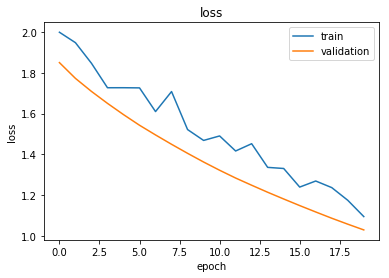

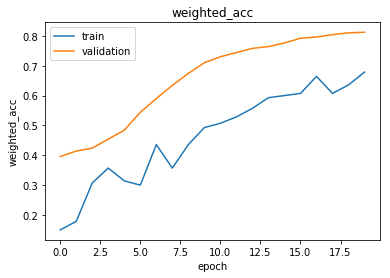

In [20]:
plot_history(history)

Evaluate the trained model on the test set

In [21]:
test_gen = generator.flow(test_data.index, test_targets)

In [22]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0541
	weighted_acc: 0.8046


# Node and link importance via saliency maps

In [23]:
from stellargraph.utils.saliency_maps.integrated_gradients import IntegratedGradients

Select the target node whose prediction is to be interpreted

In [24]:
target_idx = 1

Node id of the target node:

In [25]:
target_nid = list(G.nodes())[target_idx]
y_true = all_targets[list(node_ids).index(target_nid)]  # true class of the target node

In [26]:
N = len(node_ids)
[X, A], _, _ = train_gen.__getitem__(0)

y_pred = model.predict([X, A], batch_size=N)[target_idx]  # predicted class of the target node
class_of_interest = np.argmax(y_pred)

print("target node id: {}, \ntrue label: {}, \npredicted label: {}".format(target_nid, y_true, y_pred.round(2)))

target node id: 1033, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label: [0.07 0.53 0.1  0.07 0.08 0.08 0.07]


Get the node feature importance by using integrated gradients

In [27]:
int_grad_saliency = IntegratedGradients(model)

/Users/tys017/anaconda3/envs/stellars_py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
integrated_node_importance = int_grad_saliency.get_node_importance(X, A, target_idx, class_of_interest, steps=50)

In [29]:
print('\nintegrated_node_importance', integrated_node_importance.round(2))
print('integrated self-importance of target node {}: {}'.format(target_nid, integrated_node_importance[target_idx].round(2)))


integrated_node_importance [ 4.17  3.03 -0.   ...  0.    0.    0.  ]
integrated self-importance of target node 1033: 3.03


Check that number of non-zero node importance values matches the number of nodes in target node's 2-hop ego net

In [30]:
G_ego = nx.ego_graph(G, target_nid, radius=len(gat.activations))

In [35]:
print("\nEgo net of target node {} has {} nodes".format(target_nid, G_ego.number_of_nodes()))
print("integrated_node_importance has {} non-zero elements".format(
    sum([i != 0 for i in integrated_node_importance])))


Ego net of target node 1033 has 186 nodes
integrated_node_importance has 186 non-zero elements


Compute the link importance by integrated gradients. Note that the importance for existing and potential edges are computed differently.

In [36]:
integrate_link_mask = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, steps=20)
print('integrated_link_mask.shape = {}'.format(integrate_link_mask.shape))

integrated_link_mask.shape = (2708, 2708)


In [37]:
integrate_link_mask_add = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, steps=20, non_exist_edge=True)
print('integrate_link_mask_add.shape = {}'.format(integrate_link_mask_add.shape))

Some sanity checks:

In [114]:
print("Number of edges in the graph: {} \nNumber of non-zero elements in A: {}".format(G.number_of_edges(), np.sum(A)))
print("Number of non-zero elements in integrate_link_mask: {}".format(np.count_nonzero(integrate_link_mask)))

Number of edges in the graph: 5278 
Number of non-zero elements in A: 10556
Number of non-zero elements in integrate_link_mask: 839


We expect `integrate_link_mask` to have non-zero elements corresponding to real edges in the graph, i.e., to non-zero elements of the adjacency matrix A. I.e., the below sum should be 0 (or small, if there are small importances for non-existing edges due to machine precision errors)

In [121]:
np.sum(np.ma.masked_array(integrate_link_mask, mask=A))   # expect to be zero/small

54350935921.49219

In [71]:
print("\nEgo net of target node {} has {} edges".format(target_nid, G_ego.number_of_edges()))
print("integrate_link_mask has {} non-zero elements".format(
    sum([i != 0 for i in (integrate_link_mask.transpose() @ integrate_link_mask)[target_idx,:]])))


Ego net of target node 1033 has 369 edges
integrate_link_mask has 436 non-zero elements


In [80]:
adj_2 = (A.transpose() @ A)

In [102]:
# number of edges in a 2-hop ego net of target_idx node:
np.sum(A[target_idx,:]) + np.sum(adj_2[target_idx,:])

203

- Evaluate link importances in G_ego.edges() from `integrate_link_mask` and `integrate_link_mask_add`, and add them as importance attribute to G_ego.edges()
- Plot G_ego with edge importances

- Evaluate node importances in G_ego.nodes() from `integrated_node_importance`, and add them as importance attribute to G_ego.nodes()
- Plot G_ego with node and edge importances, combined

In [39]:
integrated_link_importance_rank = [(int(k/N), k%N) for k in np.argsort(integrate_link_mask.flatten().reshape(-1))][::-1]
integrated_link_importance_rank_add = [(int(k/N), k%N) for k in np.argsort(integrate_link_mask_add.flatten().reshape(-1))][::-1]

In [112]:
topk = 10
print('Top {} most important links by integrated gradients are {}'.format(topk, integrated_link_importance_rank[-topk:]))
print('Top {} most important links by integrated gradients (for potential edges) are {}'.format(topk, integrated_link_importance_rank_add[-topk:]))

Top 10 most important links by integrated gradients are [(1, 1), (1, 1855), (1, 1886), (1, 1887), (1, 1770), (1, 1769), (1, 1732), (1, 1497), (1, 65), (1, 95)]
Top 10 most important links by integrated gradients (for potential edges) are [(1, 714), (1, 818), (1, 2596), (1, 332), (1, 1857), (1, 1856), (1, 0), (1, 329), (1, 324), (1, 1814)]


In [32]:
nx.set_node_attributes(G_ego, values={x[0]:{'subject': x[1]} for x in node_data['subject'].items()})

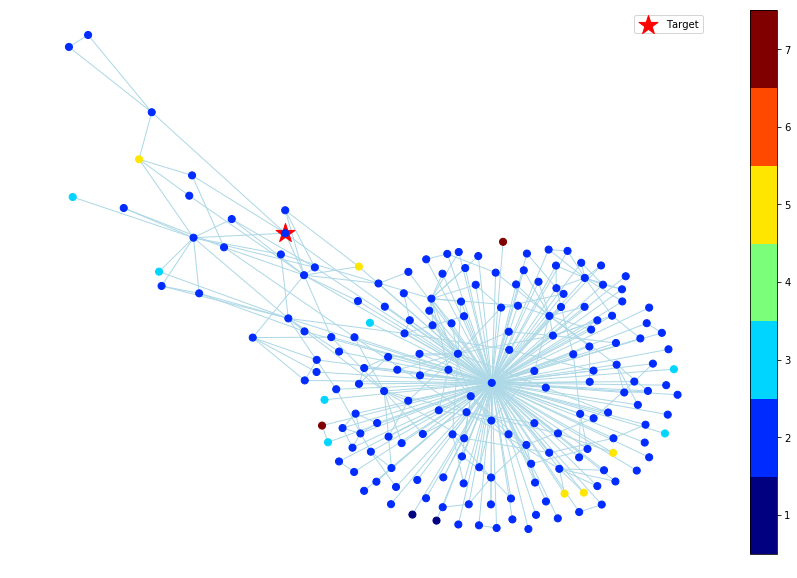

In [34]:
nodes = G_ego.nodes()
colors = pd.DataFrame([v[1]['subject'] for v in G_ego.nodes(data=True)], index=nodes, columns=['subject'])
colors = np.argmax(target_encoding.transform(colors.to_dict('records')), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=400, node_color='r', node_shape='*', label="Target")
cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=nodes, node_color=colors, cmap=cmap, node_size=50, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5)
ec = nx.draw_networkx_edges(G_ego, pos, edge_color='lightblue')
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()